In [1]:
%pylab inline

import pickle

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

Populating the interactive namespace from numpy and matplotlib


# Import des données

In [2]:
# Remplacer ceci par l'import de vos données
X, y = make_classification(n_samples=10000)

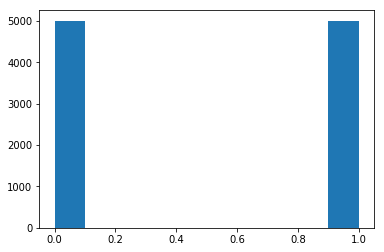

In [3]:
# Regardons la répartition de notre objectif
plt.hist(y)
None

# Division en Train set / Test set

In [4]:
# On utilise un split standard de 75%-25%  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Training

## Premier essai naïf

In [5]:
# On essaie avec un arbre
model = RandomForestClassifier(n_estimators=1)

model.fit(X_train, y_train)
print(f'Training score {accuracy_score(model.predict(X_train), y_train) * 100:.1f}%')

print(f'Test score     {accuracy_score(model.predict(X_test), y_test) * 100:.1f}%')

Training score 93.9%
Test score     84.1%


In [6]:
# On définit une fonction que l'on va réutiliser pour scorer différents modèles

def score_model(model):
    """Réalise la validation croisée d'un modèle sur le training set uniquement
    puis affiche les résultats (moyenne et écart-type de la précision du modèle)"""
    results = cross_val_score(model,
                              X_train,
                              y_train,
                              scoring=make_scorer(accuracy_score),
                              cv=3)
    print(f'Moyenne : {results.mean() * 100:.1f}%, Ecart-Type : {results.std() * 100:.1f}%')

In [7]:
%%time

# On réessaie le même modèle avec la validation croisée
model = RandomForestClassifier(n_estimators=1)
score_model(model)

Moyenne : 85.5%, Ecart-Type : 1.2%
CPU times: user 61.4 ms, sys: 3.92 ms, total: 65.4 ms
Wall time: 53.6 ms


### À quoi ça sert si on peut juste utiliser le test set ?

Et bien ça sert à **VALIDER**, le test set étant idéalement utilisé **UNE SEULE FOIS** une fois que vous aurez choisi le modèle à garder (le modèle *validé*).

Si on teste tous nos essais sur le test set, on a juste choisi le modèle qui fait le meilleur score sur le test set pas le modèle qui fait le meilleur score en général.

Cela peut mener aveuglément à des modèles qui sont **Excellents** sur le papier et **Mauvais** en production...


On utilise donc la validation croisée sur le training set.

## Essais de quelques configurations "à la main"

In [8]:
%%time

# On essaie avec deux arbres
model = RandomForestClassifier(n_estimators=2)
score_model(model)

Moyenne : 85.7%, Ecart-Type : 0.4%
CPU times: user 86.8 ms, sys: 2.31 ms, total: 89.1 ms
Wall time: 88.6 ms


In [9]:
%%time

# 10...
model = RandomForestClassifier(n_estimators=10)
score_model(model)

Moyenne : 90.5%, Ecart-Type : 0.9%
CPU times: user 374 ms, sys: 2.5 ms, total: 376 ms
Wall time: 375 ms


In [10]:
%%time

# 1000...
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
score_model(model)

Moyenne : 91.1%, Ecart-Type : 0.5%
CPU times: user 3.73 s, sys: 503 ms, total: 4.23 s
Wall time: 18.8 s


## Tester des combinaisons de manière automatisée

In [11]:
%%time

model = RandomForestClassifier()
parameter_grid = {
    'n_estimators': [1, 10, 100, 1000],
    'max_depth'   : [2, 5, 10],
}

search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=3)

search.fit(X_train, y_train)

params = search.best_params_
print(f'Meilleurs paramètres: {search.best_params_}')
print(f'Meilleur score      : {search.best_score_}')

Meilleurs paramètres: {'max_depth': 10, 'n_estimators': 100}
Meilleur score      : 0.9090666666666667
CPU times: user 1min 8s, sys: 204 ms, total: 1min 8s
Wall time: 1min 9s


# Evaluation Finale

In [12]:
# On a trouvé les meilleurs paramètres (parmi ceux cherchés...)
# On va les utiliser pour entrainer le modèle sur tout le dataset
# Puis on évalue le modèle obtenu sur le test set

model = RandomForestClassifier(**params)
model.fit(X_train, y_train)

print(f'Score du modèle (précision) : {accuracy_score(model.predict(X_test), y_test) * 100:.1f}%')

Score du modèle (précision) : 90.1%


# Sauvegarde du modèle

In [13]:
# On sérialize le modèle sur disque
# On pourra ainsi le mettre à disposition dans une API, directement dans un moteur de prédiction, etc
with open('model.pkl', 'wb') as file_model:
    pickle.dump(model, file_model)

Notebook disponible sur github :
    https://github.com/olivierdolle/esipe